<a href="https://colab.research.google.com/github/tamirhouri/deep-reinforcement-learning-minigrid-ppo/blob/main/Deep_RL_Minigrid_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcements Learning - Minigrid - Inference

### Name and ID:
Student 1: Almog Zemach (205789001)
<br>
Student 2: Tamir Houri (205668627)
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

## Pre-Requisit

### Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gymnasium
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre
!pip install minigrid
!wget -q https://www.dropbox.com/scl/fi/jhkb2y3jw8wgin9e26ooc/MiniGrid-MultiRoom-N6-v0_vid.mp4?rlkey=qtkrmmbk9aiote5z7w4bx6ixi&st=zbr4gk21&dl=1 -O content/MiniGrid-MultiRoom-N6-v0_vid.mp4


### Imports

In [ ]:
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pyvirtualdisplay
import IPython
import base64
import gymnasium
import minigrid
from minigrid.wrappers import RGBImgObsWrapper, RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper, RGBImgPartialObsWrapper
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque
import random
import os
import json
import csv
import gdown
from google.colab import drive
from datetime import datetime
import pandas as pd

In [ ]:
# Constants for the environemnt configuration do no change the values
highlight = False
render_mode = "rgb_array"

### Environment

In [ ]:
ENVS = {
    "S": "MiniGrid-MultiRoom-N2-S4-v0",
    "M": "MiniGrid-MultiRoom-N4-S5-v0",
    "L": "MiniGrid-MultiRoom-N6-v0"
}

def create_env(env_name):
    env = gymnasium.make(env_name, render_mode=render_mode, highlight=highlight)
    env = RGBImgPartialObsWrapper(env)
    env = ImgObsWrapper(env)
    return env

env = create_env(ENVS["L"])
obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print(f"Observation Shape: {obs_shape}, Actions: {n_actions}")

Observation Shape: (56, 56, 3), Actions: 7


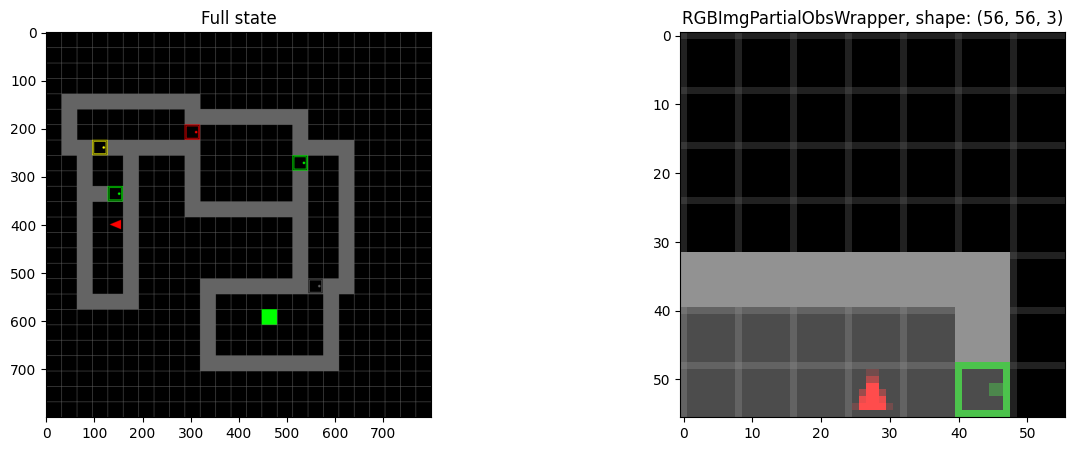

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
obs, _ = env.reset()
axs[1].imshow(obs)
axs[1].title.set_text(f'RGBImgPartialObsWrapper, shape: {obs.shape}')
axs[0].imshow(env.render())
axs[0].title.set_text(f'Full state')
plt.show()

## Utils

### Obs Preprocess

In [ ]:
def stack_obs_queue(obs_queue):
  gray_images = [cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY) for obs in obs_queue]
  stacked_tensor = np.stack(gray_images, axis=-1)
  return stacked_tensor

def take_last(obs_queue):
  return obs_queue[-1]

### Video

In [ ]:
def create_video(env, agent, video_filename, N_f=1, obs_preprocess=take_last):
    assert N_f > 0
    assert obs_preprocess is not None

    with imageio.get_writer(video_filename, fps=16) as video:
      obs, _ = env.reset()
      frame_stack = deque([obs for _ in range(N_f)], maxlen=N_f)
      done = False
      while not done:
          result = agent.get_action(obs_preprocess(frame_stack))
          action = result

          obs, reward, terminate, truncated, _ = env.step(action)
          frame_stack.append(obs)
          done = terminate or truncated
          video.append_data(env.render())

In [ ]:
class VideoEmbedder:
    def add_video(self, filename):
        """Add a single video to the accumulated display."""
        video = open(filename, 'rb').read()
        b64 = base64.b64encode(video).decode()
        video_tag = f'''
        <video width="640" height="480" controls style="margin: 10px;">
            <source src="data:video/mp4;base64,{b64}" type="video/mp4">
            Your browser does not support the video tag.
        </video>'''

        IPython.display.display(IPython.display.HTML(video_tag))

embedder = VideoEmbedder()

### Google Drive Downloader

In [ ]:
def download_from_gdrive(gdrive_file_id, out_file):
    gdown.download(f"https://drive.google.com/uc?id={gdrive_file_id}", out_file, quiet=False)
    print("Google Drive download completed!")

## Models

### Feature Extractor

In [ ]:
def build_feature_extractor(input_shape):
    inputs = layers.Input(shape=input_shape)
    scaled_inputs = layers.Rescaling(scale=1.0 / 255.0)(inputs)

    x = layers.Conv2D(16, (3, 3), activation="relu")(scaled_inputs)
    x = layers.Conv2D(32, (3, 3), activation="relu")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.Flatten()(x)

    return inputs, x

### Dueling DQN

In [ ]:
def build_dueling_dqn(input_shape, action_size):
    inputs, x = build_feature_extractor(input_shape)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.LayerNormalization()(x)

    value = layers.Dense(1, activation='linear')(x)
    advantage = layers.Dense(action_size, activation='linear')(x)

    advantage_mean = layers.Lambda(
        lambda a: a - tf.reduce_mean(a, axis=1, keepdims=True), output_shape=lambda s: s
        )(advantage)

    q_values = layers.Lambda(
        lambda inputs: inputs[0] + inputs[1], output_shape=lambda s: s[0]
        )([value, advantage_mean])

    model = keras.Model(inputs, q_values)

    return model

dueling_dqn = build_dueling_dqn(obs_shape, n_actions)

### PPO (Actor-Critic)

In [ ]:
def build_ppo_models(input_shape, action_dim):
    # Actor Network
    actor_inputs, x = build_feature_extractor(input_shape)
    x = layers.Dense(64, activation="relu")(x)
    policy_logits = layers.Dense(action_dim, activation="softmax")(x)
    actor = keras.Model(actor_inputs, policy_logits)

    # Critic Network
    critic_inputs, y = build_feature_extractor(input_shape)
    y = layers.Dense(64, activation="relu")(y)
    value = layers.Dense(1, activation="linear")(y)
    critic = keras.Model(critic_inputs, value)

    return actor, critic

actor, critic = build_ppo_models(obs_shape, n_actions)


## Agents

### Base Agent

In [ ]:
from abc import ABC, abstractmethod


class BaseInferenceAgent(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def get_action(self, state):
        pass

    @abstractmethod
    def load_weights(self, weights_path):
      pass


### DuelingDQNAgent

In [ ]:
class DuelingDQNAgent(BaseInferenceAgent):
    def __init__(self, state_dim, action_dim):
        self.model = build_dueling_dqn(state_dim, action_dim)
        self.gdrive_file_id = "1-49hbPsUfD2dZNTAB7e507p4WqZgN1fM"
        self.weights_path = "/content/ddqn.weights.h5"

    def get_action(self, state):
        state = np.expand_dims(state, axis=0).astype(np.float32)
        q_values = self.model.predict(state, verbose=0)[0]
        return np.argmax(q_values)

    def load_weights(self):
        download_from_gdrive(self.gdrive_file_id, self.weights_path)
        self.model.load_weights(self.weights_path)

### PPOAgent

In [ ]:
class PPOAgent(BaseInferenceAgent):
    def __init__(self, obs_shape, action_dim):
        self.actor, _ = build_ppo_models(obs_shape, action_dim)
        self.gdrive_file_id = "1-ow7xjZUg1hFhfpTl58FMp3sXzSqww2k"
        self.weights_path = "/content/ppo.weights.h5"

    def get_action(self, state):
        state = np.expand_dims(state, axis=0)
        action_probs = self.actor.predict(state, verbose=0)[0]

        return np.argmax(action_probs)

    def load_weights(self):
        download_from_gdrive(self.gdrive_file_id, self.weights_path)
        self.actor.load_weights(self.weights_path)

## Inference

#### Agents setup with learned policy

In [ ]:
# Create agents
algorithms = [
    { "name": "Dueling DQN", "agent": DuelingDQNAgent(obs_shape, n_actions), "N_f": 3, "obs_preprocess": stack_obs_queue },
    { "name": "PPO", "agent": PPOAgent(obs_shape, n_actions), "N_f": 1, "obs_preprocess": take_last },
]

# Load policies
for algo in algorithms:
    try:
      algo["agent"].load_weights()
    except:
      print(f'Unable to load weights for {algo["name"]}')

Downloading...
From (original): https://drive.google.com/uc?id=1-49hbPsUfD2dZNTAB7e507p4WqZgN1fM
From (redirected): https://drive.google.com/uc?id=1-49hbPsUfD2dZNTAB7e507p4WqZgN1fM&confirm=t&uuid=888db483-a997-44bf-806e-d4e5ef6b400b
To: /content/ddqn.weights.h5
100%|██████████| 246M/246M [00:05<00:00, 48.9MB/s]


Google Drive download completed!


Downloading...
From (original): https://drive.google.com/uc?id=1-ow7xjZUg1hFhfpTl58FMp3sXzSqww2k
From (redirected): https://drive.google.com/uc?id=1-ow7xjZUg1hFhfpTl58FMp3sXzSqww2k&confirm=t&uuid=29cedab7-cea4-4382-9abe-6f6a45c7e8e7
To: /content/ppo.weights.h5
100%|██████████| 123M/123M [00:01<00:00, 92.9MB/s]


Google Drive download completed!


#### Agents Validation

In [ ]:
VALIDATION_EPISODES = 100
MAX_STEPS = 120

seeds = [
    random.randint(0, 100000) for _ in range(VALIDATION_EPISODES)
]

env = create_env(ENVS["L"])

def validate_agent(agent_name, agent, N_f, obs_preprocess, num_episods=VALIDATION_EPISODES):
    validation_results = []

    print(f"Starting validation for {agent.__class__.__name__}")

    for episode in range(num_episods):
        obs, _ = env.reset(seed=seeds[episode])
        stacked_frames = deque([obs for _ in range(N_f)], maxlen=N_f)
        total_reward = 0
        total_loss = 0
        done = False
        steps = 0

        while not done:
            action = agent.get_action(obs_preprocess(stacked_frames))
            obs, reward, terminate, truncated, _ = env.step(action)
            stacked_frames.append(obs)
            done = terminate or truncated
            total_reward += reward
            steps += 1

        validation_results.append((episode, total_reward, steps, terminate))

        if (episode + 1) % 20 == 0:
            print(f"[Episode {episode+1}/{num_episods}] Total Rewards: {total_reward:.3f}, Steps: {steps}")

    with open(f"{agent.__class__.__name__}_validation_results.csv", mode="w", newline='') as file:
        writer = csv.writer(file)
        writer.writerow(("episode", "total_reward", "steps", "terminate"))
        writer.writerows(validation_results)

    return validation_results


In [ ]:
validation_results = {
    algo["name"]: validate_agent(algo["name"], algo["agent"], algo["N_f"], algo["obs_preprocess"])
    for algo in algorithms
}

Starting validation for DuelingDQNAgent
[Episode 20/100] Total Rewards: 0.670, Steps: 44
[Episode 40/100] Total Rewards: 0.685, Steps: 42
[Episode 60/100] Total Rewards: 0.633, Steps: 49
[Episode 80/100] Total Rewards: 0.573, Steps: 57
[Episode 100/100] Total Rewards: 0.000, Steps: 120
Starting validation for PPOAgent
[Episode 20/100] Total Rewards: 0.700, Steps: 40
[Episode 40/100] Total Rewards: 0.655, Steps: 46
[Episode 60/100] Total Rewards: 0.655, Steps: 46
[Episode 80/100] Total Rewards: 0.640, Steps: 48
[Episode 100/100] Total Rewards: 0.520, Steps: 64


In [ ]:
for algo in algorithms:
    print(f'Algorithm: {algo["name"]}')

    video_file_name = f'{algo["agent"].__class__.__name__}_vid.mp4'
    create_video(env, algo["agent"], video_file_name, algo["N_f"], algo["obs_preprocess"])
    embedder.add_video(video_file_name)

Algorithm: Dueling DQN


Algorithm: PPO


#### Performance Metrics

### Utils

In [ ]:
plt_colors = ['dodgerblue', 'blueviolet']

In [ ]:
def plot_agent_performance(validation_results):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    bar_width = 0.35  # Width of each bar
    x_pos = np.arange(len(validation_results))  # X positions for the bars

    for i, (name, results) in enumerate(validation_results.items()):
      df = pd.DataFrame(results, columns=['episode', 'total_reward', 'steps', 'terminate'])
      df = df.astype({'episode': int, 'total_reward': float, 'steps': int, 'terminate': int})

      success_rate = df['terminate'].sum() / len(df)
      average_total_reward = df['total_reward'].mean()
      median_total_reward = df['total_reward'].median()
      average_steps = df['steps'].mean()
      median_steps = df['steps'].median()

      axes[0].bar(name, success_rate, color=plt_colors[i])
      axes[0].set_ylabel('Success Rate')
      axes[0].set_title('Success Rate')
      axes[0].set_ylim([0, 1])
      axes[0].text(i, success_rate + 0.02, f"{success_rate:.2f}", ha='center')

      # Average total reward
      axes[1].bar(((-1) ** x_pos[i]) * bar_width/2, average_total_reward, bar_width, label=name, color=plt_colors[i])
      axes[1].text(((-1) ** x_pos[i]) * bar_width/2, average_total_reward + 0.02, f"{(average_total_reward):.2f}", ha='center')

      # Median total reward
      axes[1].bar(1 + ((-1) ** x_pos[i]) * bar_width/2, median_total_reward, bar_width, color=plt_colors[i])
      axes[1].text(1 + ((-1) ** x_pos[i]) * bar_width/2, median_total_reward + 0.02, f"{(median_total_reward):.2f}", ha='center')

      axes[1].set_ylabel('Total Reward')
      axes[1].set_title('Average and Median Total Reward')
      axes[1].set_xticks(x_pos)
      axes[1].set_xticklabels(['Average', 'Median'])
      axes[1].set_ylim([0, 1])
      axes[1].legend()

      # Average steps
      axes[2].bar(((-1) ** x_pos[i]) * bar_width/2, average_steps, bar_width, label=name, color=plt_colors[i])
      axes[2].text(((-1) ** x_pos[i]) * bar_width/2, average_steps + 2, f"{(average_steps):.2f}", ha='center')

      # Median steps
      axes[2].bar(1 + ((-1) ** x_pos[i]) * bar_width/2, median_steps, bar_width, color=plt_colors[i])
      axes[2].text(1 + ((-1) ** x_pos[i]) * bar_width/2, median_steps + 2, f"{(median_steps):.2f}", ha='center')

      axes[2].set_ylabel('Steps')
      axes[2].set_title('Average and Median Steps')
      axes[2].set_xticks(x_pos)
      axes[2].set_xticklabels(['Average', 'Median'])
      axes[2].set_ylim([0, 100])
      axes[2].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_average_steps(validation_results):
    plt.figure(figsize=(10, 5))

    for i, (name, results) in enumerate(validation_results.items()):
        steps = [res[2] for res in results]
        average_steps = []
        for j in range(len(steps)):
          average_steps.append(np.mean(steps[max(0, i-24):j+1])) # Average of the last 25 episodes

        plt.plot(range(len(steps)), average_steps, 'o-', label=name, color=plt_colors[i])

    plt.xlabel("Episode")
    plt.ylabel("Average Steps (last 25 episodes)")
    plt.title("Average Number of Steps to Complete Episode (last 25 episodes)")
    plt.legend()
    plt.grid(True)
    plt.show()



### Plots

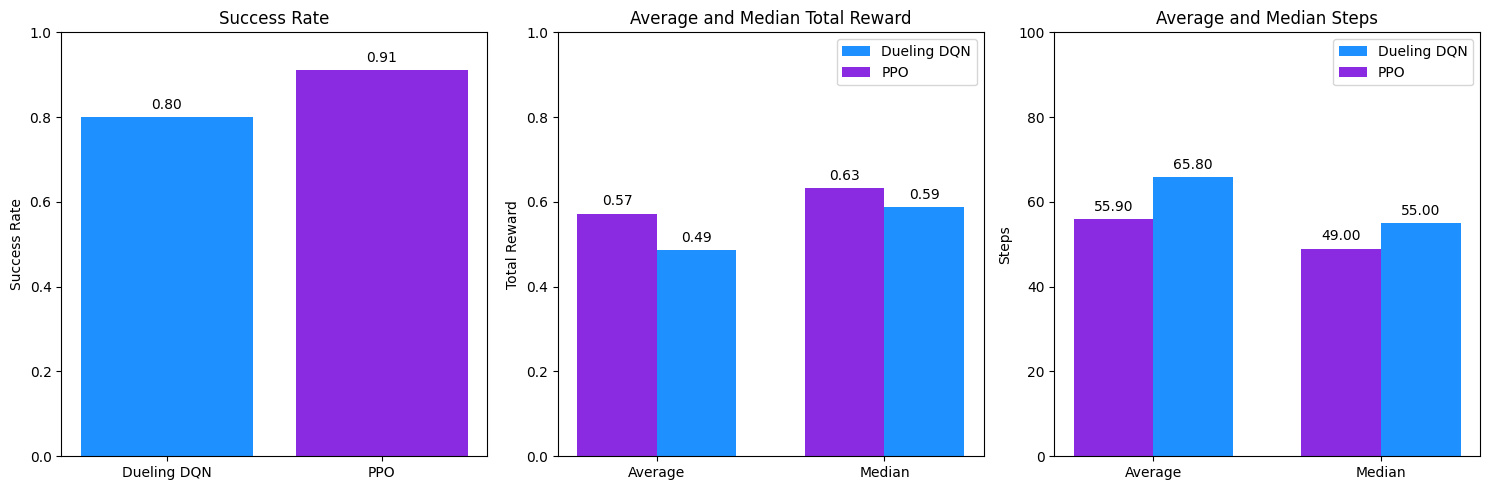

In [ ]:
plot_agent_performance(validation_results)

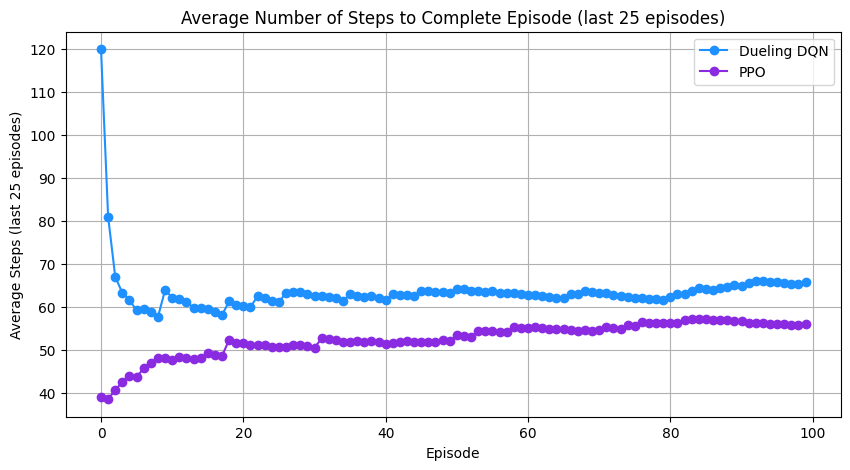

In [ ]:
plot_average_steps(validation_results)